Notebook for training the NN. Training data stack should already be made, but noise can/will be added here. 

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore", module="torch.nn.functional")

import sys
sys.path.append("../helpers/")
from image_helpers import * 

from atomai.transforms import datatransform # only dependency from this package, could/should be removed
from sklearn.model_selection import train_test_split

from smallUnet import *
from skyrm_find_CNN import *
from image_helpers import * 

%matplotlib notebook
print(f"Torch GPU is available: {torch.cuda.is_available()}")

Torch GPU is available: True


In [3]:
NN_name = "skNet_batch1_210625"
savedir = './NN_trained/' # dir to save results

#### If loading a NN

In [9]:
# nn_path = "/atoz/Lorentz/Arthur/code/skyrm_CNN/NN_cooling2_1800/smallUnet-finalrot.pt"
# model = smallUnet()
# model.cuda()
# model.load_state_dict(torch.load(nn_path))
# model.eval()

# # specify optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # lr is a learniing rate

## load training data

In [4]:
dataset = np.load('./training_data/batch1/200318_combrot.npz')
test_split = 0.2
batch_size = 64 
epochs = 600 # 

In [5]:
images_load = dataset['Images']
labels_load = dataset['Labels']
assert images_load.shape[0] == labels_load.shape[0]
print(f"Total size Images, Labels:\n {images_load.shape, labels_load.shape}")
print(f"Number training images: {int(images_load.shape[0]*(1-test_split))}")
print(f"Number test images: {int(images_load.shape[0]*(test_split))}")

Total size Images, Labels:
 ((3000, 256, 256), (3000, 256, 256))
Number training images: 2400
Number test images: 600


# apply noise to training data
uses a [datatransformer from the atomai package](https://atomai.readthedocs.io/en/latest/other_utilities.html?highlight=datatransform#atomai.transforms.datatransform) because it was convenient way to add noise, but this dependency could be easily removed. 

In [6]:
import textwrap
def training_log(name=None, savedir=None, images=None, labels=None, test_split=None, 
                 batch_size=None, epochs=None, n_channels=None, dim_order_in=None, 
                 dim_order_out=None, gauss_noise=None, poisson_noise=None, 
                 salt_and_pepper=None, contrast=None, blur=None, zoom=None, 
                 rotation=None, seed=None, notes=None):
    
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    
    log_name = os.path.join(savedir, name + "_training_data_params.txt")
    with open(log_name, "w") as txt:
        txt.write(textwrap.dedent(f"""\
        NN name: {name}
        final NN savepath: {os.path.join(os.path.abspath(savedir), name + '_final.pt')}
        images shape: {np.shape(images)}
        labels shape: {np.shape(labels)}
        test split: {test_split}
        batch size: {batch_size}
        epochs: {epochs}
        
        number channels: {n_channels}
        dim_order_in: {dim_order_in}
        dim_order_out: {dim_order_out}
        
        Noise added to training/test data using atomai.transforms.datatransform():
        gauss_noise: {gauss_noise}
        poisson_noise: {poisson_noise}
        salt_and_pepper: {salt_and_pepper}
        contrast: {contrast}
        blur: {blur}
        zoom: {zoom}
        rotation: {rotation}
        seed: {seed}
        
        notes: {notes}"""))
    print(f"Saved training params file to:\n", os.path.abspath(log_name))

In [7]:
# For a single class case, we still need to explicitly specify the single channel
labels_load2 = labels_load[..., None] if np.ndim(labels_load) == 3 else labels_load
# Number of channels in masked data (the training images have a single channel)
ch = labels_load2.shape[-1]
# Define image distortion/noise parameters
zoom = False # zoom factor
poisson = [10, 45] # P noise range (scaled units)
gauss = [1, 150] # G noise range (scaled units)
blur = [1, 50] # Blurring range (scaled units)
contrast = [3, 18] # contrast range (< 10 is brighter, > 10 is darker)
salt_and_pepper = [0, 20] # min/max amount of salted/peppered pixels (scaled units)

notes = textwrap.dedent("""
Trained on rotated Skx data such that tilt axis is along x axis
(contrast is left/right)
""")

dim_order_in = 'channel_last'
dim_order_out = 'channel_first'
seed = 42
zoom = False
rotation = False

# Run the augmentor
imaug = datatransform(
    n_channels=ch, dim_order_in=dim_order_in, dim_order_out=dim_order_out, 
    gauss_noise=gauss, poisson_noise=poisson, salt_and_pepper=salt_and_pepper,
    contrast=contrast, blur=blur, zoom=zoom, rotation=rotation, seed=seed,
    squeeze_channels=True)

images_noise, labels_noise = imaug.run(images_load, labels_load2)

training_log(NN_name, savedir, images_load, labels_load2, test_split, batch_size,
             epochs, ch, dim_order_in, dim_order_out, gauss, poisson, 
             salt_and_pepper, contrast, blur, zoom, rotation, seed, notes)

labels_noise = labels_noise.squeeze()
print(images_noise.shape, labels_noise.shape)

Saved training params file to:
 /atoz/Lorentz/Arthur/code/skyrm_CNN/NN_trained/skNet_batch1_210625_training_data_params.txt
(3000, 1, 256, 256) (3000, 256, 256)


### Look at some of the augmented data

<IPython.core.display.Javascript object>


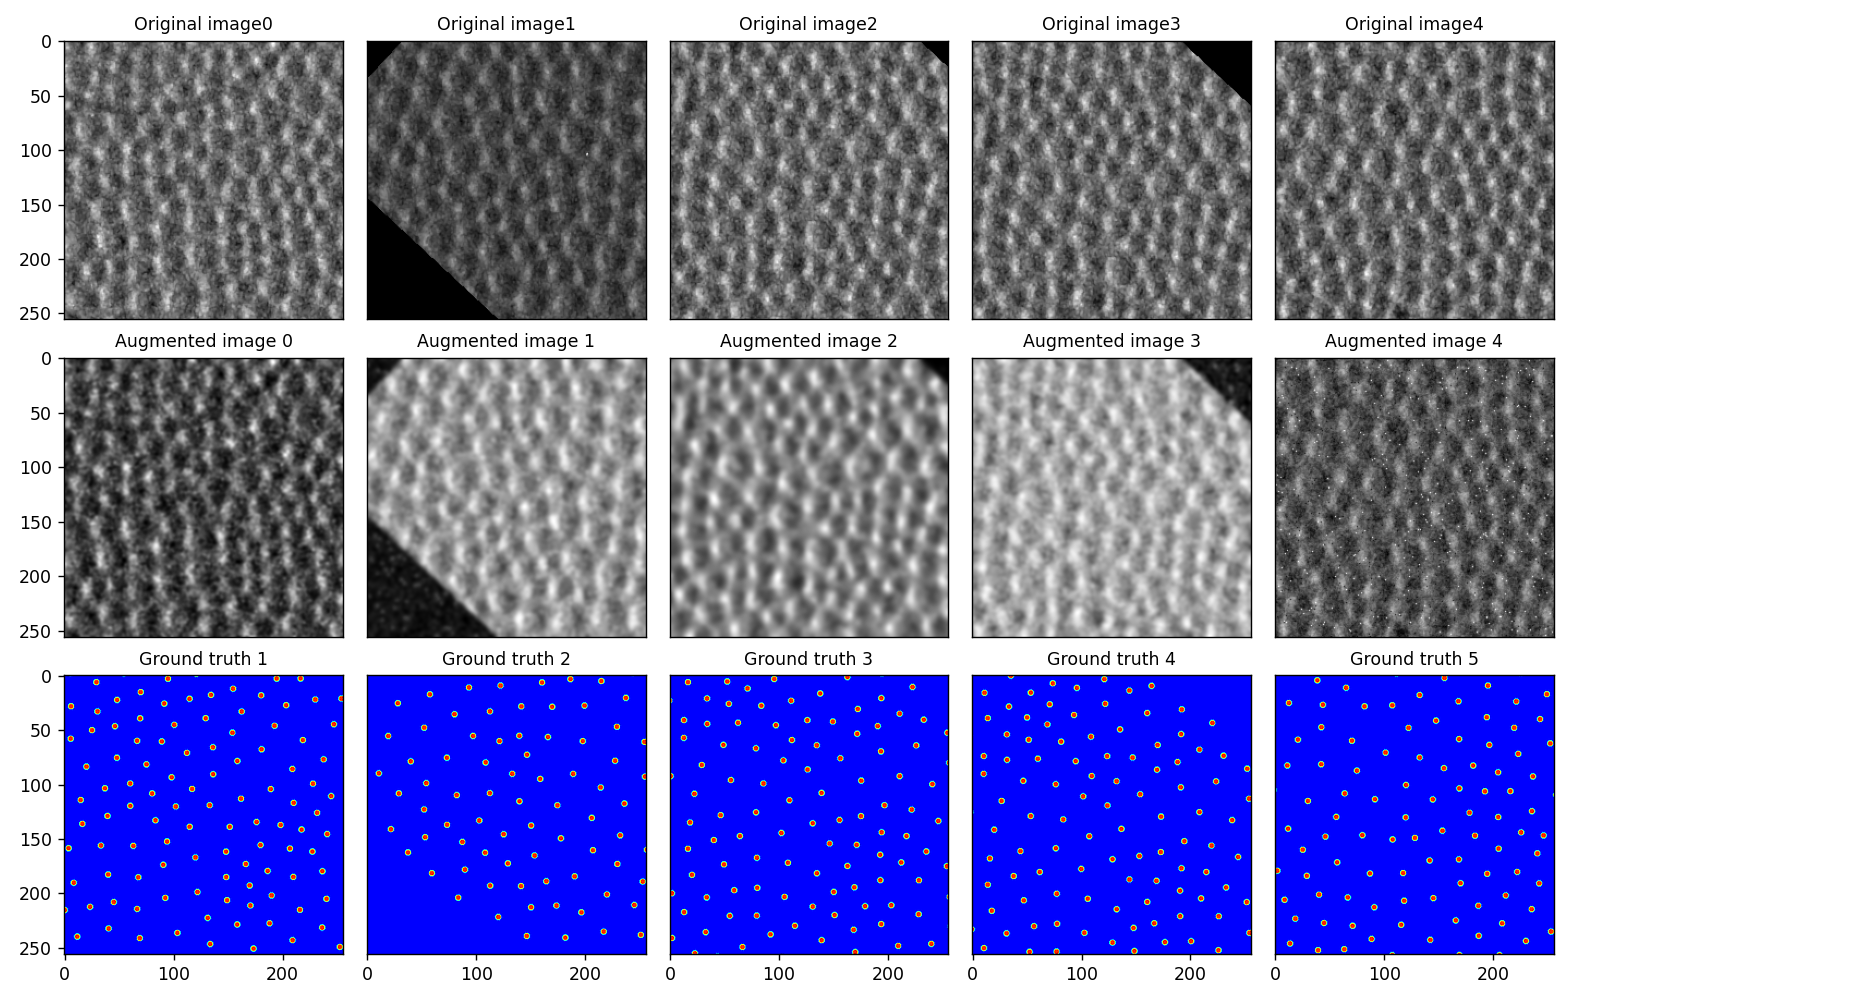

In [8]:
s=30
n = 5

n = n + 1
fig = plt.figure( figsize=(15, 8))
for i in range(1, n):   
    ax = fig.add_subplot(3, n, i)
    ax.imshow(images_load[i+s-1], cmap='gray')
    ax.set_title("Original image" + str(i-1), fontsize=10)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
        
    ax = fig.add_subplot(3, n, i+n)
    ax.imshow(images_noise[i+s-1,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1), fontsize=10)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)    
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  
    
    ax = fig.add_subplot(3, n, i+2*n)
    ax.imshow(labels_noise[i+s-1], cmap='jet', interpolation='Gaussian')
#     ax.imshow(images_noise[i+s-1,0,:,:], cmap='gray', alpha=0.5)
    
    
    ax.set_title('Ground truth ' + str(i), fontsize=10)
    if i != 1: 
        ax.tick_params(axis='y', which='both', left=False, labelleft=False)  

fig.tight_layout()
plt.show()

In [15]:
# k = 50
# plt.figure(figsize=(5, 5), dpi=100)
# plt.imshow(images_load[k], cmap='gray')
# # plt.imshow(labels_load[k], cmap='jet', alpha=.4, interpolation='Gaussian')
# plt.show()

# plt.figure(figsize=(5, 5), dpi=100)
# plt.imshow(images_noise[k][0], cmap='gray')
# # plt.imshow(labels_noise[k], cmap='jet', alpha=.4, interpolation='Gaussian')
# plt.show()

split into train/test

In [9]:
images_all, images_test_all, labels_all, labels_test_all = train_test_split(
    images_noise, labels_noise, test_size=test_split)
print(images_all.shape, labels_all.shape, images_test_all.shape, labels_test_all.shape)

(2400, 1, 256, 256) (2400, 256, 256) (600, 1, 256, 256) (600, 256, 256)


### or load already noised training data

In [17]:
# dataset = np.load('./training_data/full_training.npz')
# images_all = dataset['X_train']
# labels_all = dataset['y_train'].squeeze()
# images_test_all = dataset['X_test']
# labels_test_all = dataset['y_test'].squeeze()
# print(images_all.shape, labels_all.shape, images_test_all.shape, labels_test_all.shape)

# initialize and train a new CNN

In [14]:
rng_seed(42) # for reproducibility

# Initialize a model
model = smallUnet()
model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [15]:
n_train_batches, _ = np.divmod(labels_all.shape[0], batch_size)
n_test_batches, _ = np.divmod(labels_test_all.shape[0], batch_size)
images_allb = np.split(
    images_all[:n_train_batches*batch_size], n_train_batches)
labels_allb = np.split(
    labels_all[:n_train_batches*batch_size], n_train_batches)
images_test_allb = np.split(
    images_test_all[:n_test_batches*batch_size], n_test_batches)
labels_test_allb = np.split(
    labels_test_all[:n_test_batches*batch_size], n_test_batches)
print('image stack shape: ', np.shape(images_all))
print('batch stack shape: ', np.shape(images_allb))

image stack shape:  (2400, 1, 256, 256)
batch stack shape:  (37, 64, 1, 256, 256)


### Train

In [16]:
print_loss = 50 # print loss every m-th epoch.
# Generate sequence of random numbers for batch selection during training/testing
batch_ridx = [np.random.randint(0, len(images_allb)) for _ in range(epochs)]
batch_ridx_t = [np.random.randint(0, len(images_test_allb)) for _ in range(epochs)]
# Start training
train_losses, test_losses = [], []
for e in range(epochs):  
    model.train() # put in training mode 
    # Generate batch of training images with corresponding ground truth
    images = images_allb[batch_ridx[e]]
    labels = labels_allb[batch_ridx[e]]
    # Transform images and ground truth to torch tensors and move to GPU
    images = torch.from_numpy(images).float()
    labels = torch.from_numpy(labels).long()
    images, labels = images.cuda(), labels.cuda() 
    # Forward --> Backward --> Optimize
    optimizer.zero_grad() 
    prob = model.forward(images)
    loss = criterion(prob, labels)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # Now test the current model state using test data
    model.eval() # turn off batch norm and/or dropout units
    images_ = images_test_allb[batch_ridx_t[e]]
    labels_ = labels_test_allb[batch_ridx_t[e]]
    images_ = torch.from_numpy(images_).float()
    labels_ = torch.from_numpy(labels_).long()
    images_, labels_ = images_.cuda(), labels_.cuda()
    with torch.no_grad(): # deactivate autograd engine during testing (saves memory)
        prob = model.forward(images_)
        loss = criterion(prob, labels_)
        test_losses.append(loss.item())
    # Print statistics
    if e == 0 or (e+1) % print_loss == 0:
        print('Epoch {:3} .... Training loss: {:8} .... Test loss: {:8}'.format(
            e+1, np.around(train_losses[-1], 8), np.around(test_losses[-1], 8))
        )
    # Save the best model weights
    if e > 100 and test_losses[-1] < min(test_losses[: -1]):
        torch.save(model.state_dict(), 
                   os.path.join(savedir, NN_name + '.pt'))
# Save final weights
torch.save(model.state_dict(), 
           os.path.join(savedir, NN_name + '_final.pt'))

Epoch   1 .... Training loss: 0.91279012 .... Test loss: 0.8842172
Epoch  50 .... Training loss: 0.72424889 .... Test loss: 0.72457844
Epoch 100 .... Training loss: 0.48897675 .... Test loss: 0.50691295
Epoch 150 .... Training loss: 0.27094927 .... Test loss: 0.2691296
Epoch 200 .... Training loss: 0.15169027 .... Test loss: 0.1488912
Epoch 250 .... Training loss: 0.1013201 .... Test loss: 0.09669682
Epoch 300 .... Training loss: 0.07404278 .... Test loss: 0.07489876
Epoch 350 .... Training loss: 0.060763 .... Test loss: 0.05857509
Epoch 400 .... Training loss: 0.05459946 .... Test loss: 0.05258111
Epoch 450 .... Training loss: 0.04384105 .... Test loss: 0.04906606
Epoch 500 .... Training loss: 0.04390188 .... Test loss: 0.04169503
Epoch 550 .... Training loss: 0.03785719 .... Test loss: 0.04033171
Epoch 600 .... Training loss: 0.03883995 .... Test loss: 0.04126982


<IPython.core.display.Javascript object>


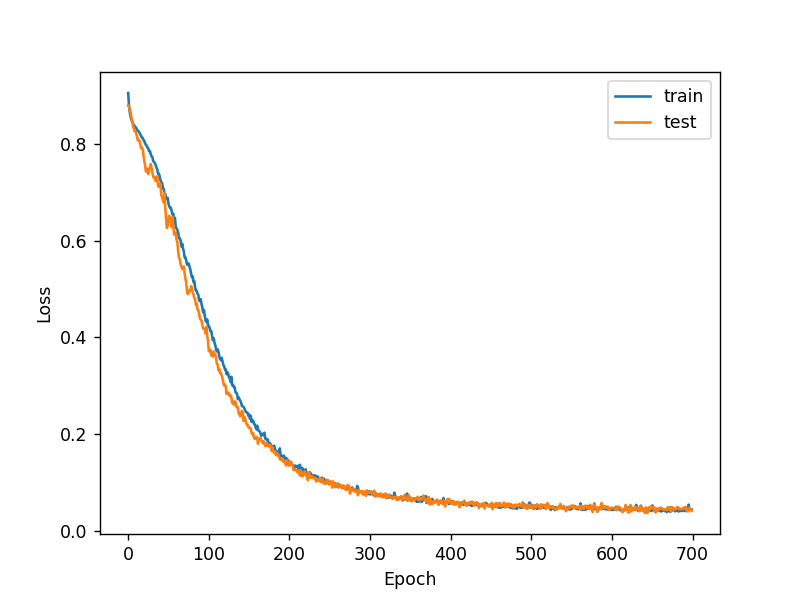

In [47]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='train')
ax.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## viewing output

<IPython.core.display.Javascript object>


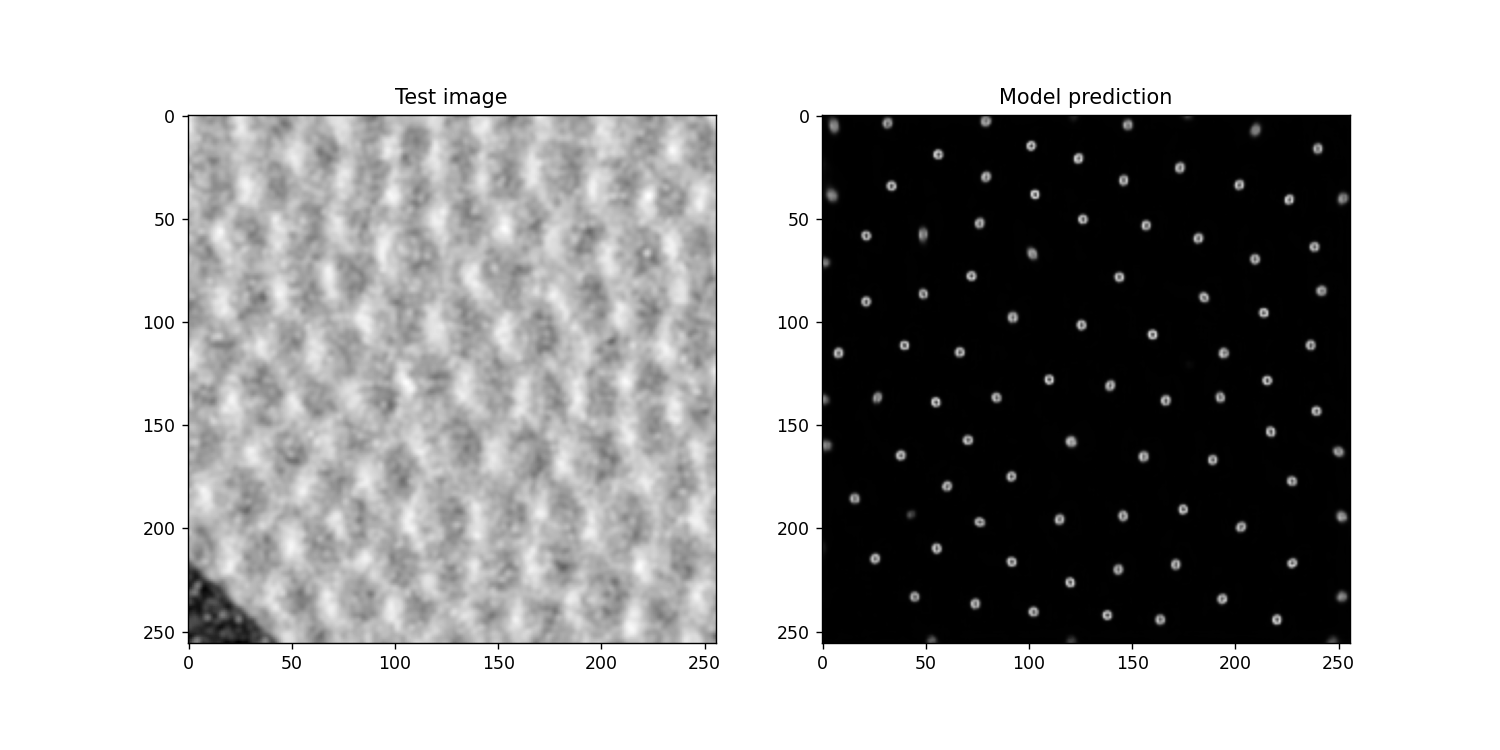

<ipython-input-17-85ec8a2c8f0b>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax2.imshow(prediction[0,:,:,1], cmap='gray', Interpolation='Gaussian')


<IPython.core.display.Javascript object>


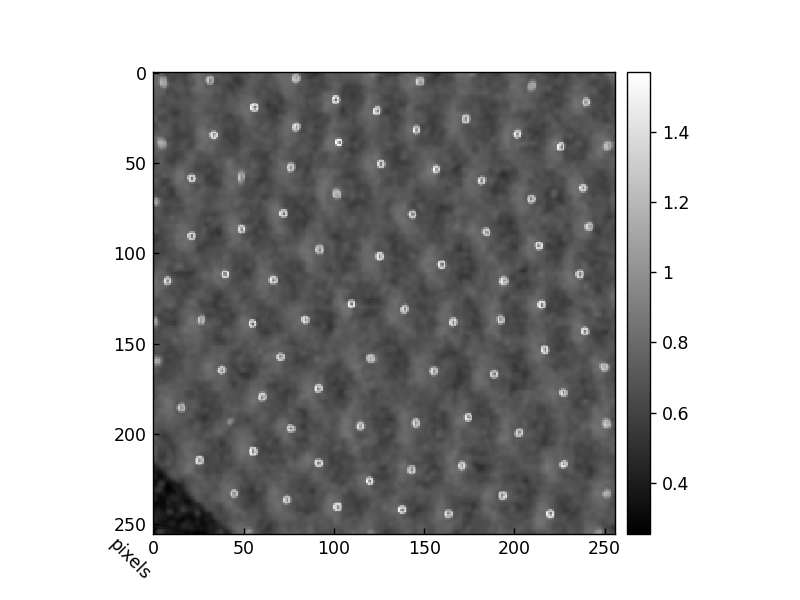

In [17]:
k, im = 2, 8 # batch, image
test_img = images_test_allb[k][im]
test_lbl = labels_test_allb[k][im]
# Convert to 4D tensor (required, even if it is a single image)
test_img = test_img[np.newaxis, ...]
# Convert to pytorch format and move to GPU
test_img_ = torch.from_numpy(test_img).float().cuda()
# make a prediction
prediction = model.forward(test_img_)
prediction = F.softmax(prediction, dim=1).cpu().detach().numpy()
prediction = np.transpose(prediction, [0, 2, 3, 1]) # rearange dimensions for plotting
# plot results
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_img[0,0], cmap='gray')
ax2.imshow(prediction[0,:,:,1], cmap='gray', Interpolation='Gaussian')
ax1.set_title('Test image')
ax2.set_title('Model prediction')

show_im(test_img[0,0] + prediction[0,:,:,1])

## Test on a full image
Skip to here if already have a trained NN 
For actual experimental data, I have a workflow for bringing in the raw TEM images, filtering them, determining the tilt axis and compensating for tilt angle, etc., but for this example just using an already processed image. 

<IPython.core.display.Javascript object>


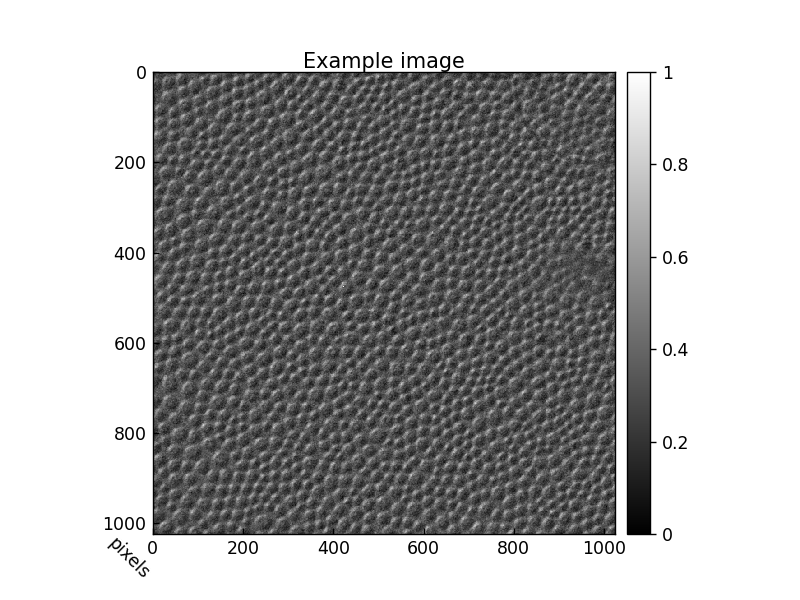

In [33]:
test_im = np.load("./test_data/150K_test.npy")
tilt_dir = 132.137 # tilt axis
show_im(test_im, title="Example image")

<IPython.core.display.Javascript object>


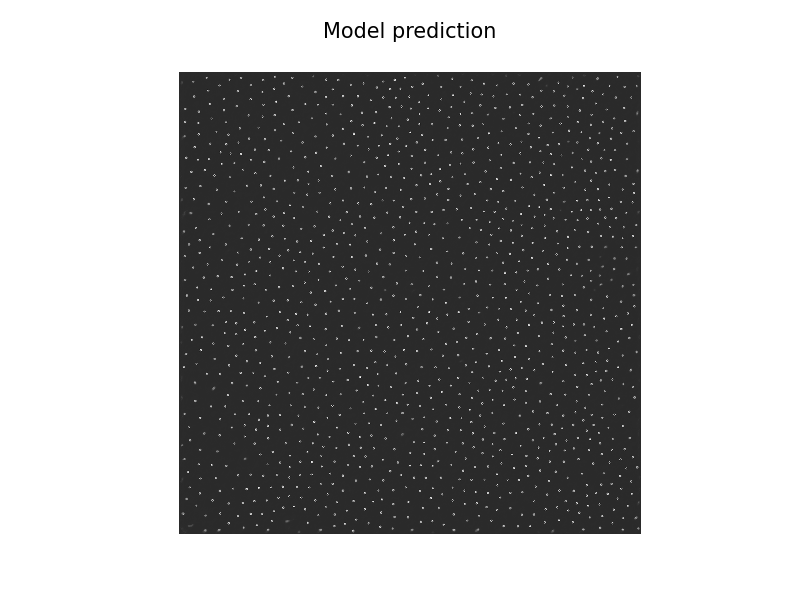

<IPython.core.display.Javascript object>


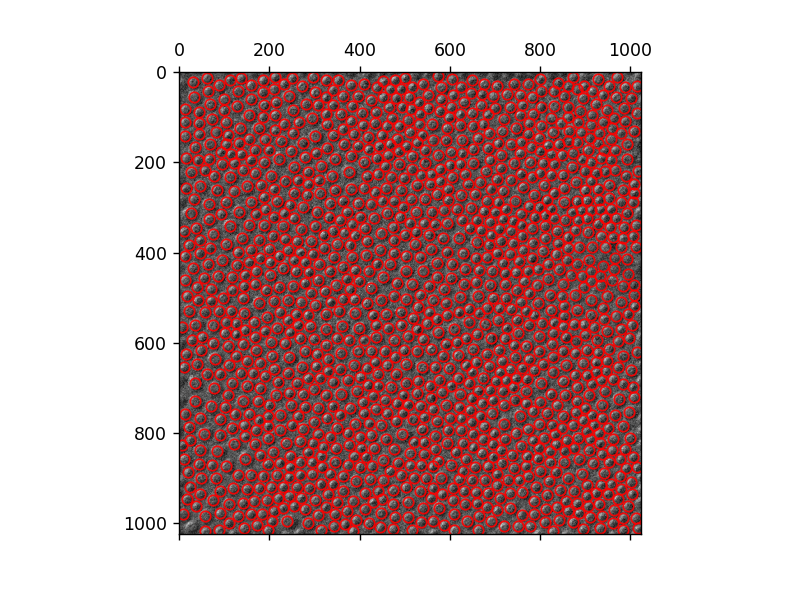

In [35]:
nn_path = os.path.join(savedir, NN_name + "_final.pt")
model = trained_NN(nn_path, cuda=True)
centers = model.find_skyrms(test_im, tilt_dir, thresh=0.3)
show_im(model.prediction[:,:,0], "Model prediction", simple=True)
show_im_peaks(test_im, centers, "Skyrmion locations")